In [1]:
from keras.layers import (
    Input,
    Activation,
    merge,
    Dense,
    Reshape
)
from keras.models import Sequential

Using Theano backend.


In [6]:
from preprocessing import *

In [3]:
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model

In [4]:
# import data.mat
import numpy as np
np.random.seed(123)  # for reproducibility
import scipy.io as sio

In [5]:
# import numpy as np
from keras import backend as K
def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))


def root_mean_square_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5


def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

# aliases
mse = MSE = mean_squared_error
rmse = RMSE = root_mean_square_error

In [5]:
def init_data(data, data_size, time_size):
    train_size = data_size - time_size
    X_train = []
    y_train = []
    for i in range(0, train_size):
        X_train.append(data[i : i + time_size, :].reshape(time_size, 2704))
        X_train[i] = X_train[i].reshape(time_size * 1, 52, 52)
        
        y_train.append(data[i + time_size, :])
        y_train[i] = y_train[i].reshape(1, 52, 52)
        
    X_train = np.array(X_train, dtype = 'float32')
    y_train = np.array(y_train, dtype = 'float32')
    return X_train, y_train

In [6]:
def MinMaxNormalization(data):
    mx = np.max(data)
    mn = np.min(data)
    data = (data - mn) / (mx - mn)
    data = data * 2 - 1
    
    return data, mx, mn

In [7]:
train_size = 2000
test_size = 100
time_size = 30

nb_epoch = 500  # number of epoch at training stage
nb_epoch_cont = 100  # number of epoch at training (cont) stage
batch_size = 32  # batch size
lr = 0.0002  # learning rate
nb_residual_unit = 12  # number of residual units

nb_flow = 1  # there are two types of flows: inflow and outflow
map_height, map_width = 52, 52  # grid size
path_result = 'RET'
path_model = 'MODEL'

In [8]:
data = sio.loadmat('data.mat')
H = data['Data']
Data = H[:train_size + test_size, ]
Data, mx, mn = MinMaxNormalization(Data)

X_train, y_train = init_data(Data, train_size, time_size)
X_test, y_test = init_data(Data[train_size:, ], test_size, time_size)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

print(mx, mn)

(1970, 30, 52, 52)
(1970, 1, 52, 52)
(70, 30, 52, 52)
(70, 1, 52, 52)
1.96337231493 0.648396878095


In [14]:
a = np.array([[1,2],[3,4]])
print(a)
print(np.max(a))
b,_,_ = MinMaxNormalization(a)
print(b)

[[1 2]
 [3 4]]
4
[[-1.         -0.33333333]
 [ 0.33333333  1.        ]]


In [15]:
def _shortcut(input, residual):
    return merge([input, residual], mode='sum')

In [16]:
def _bn_relu_conv(nb_filter, nb_row, nb_col, subsample=(1, 1), bn=False):
    def f(input):
        if bn:
            input = BatchNormalization(mode=0, axis=1)(input)
        activation = Activation('relu')(input)
        return Convolution2D(nb_filter=nb_filter, nb_row=nb_row, nb_col=nb_col, subsample=subsample, border_mode="same")(activation)
    return f

In [17]:
def _residual_unit(nb_filter, init_subsample=(1, 1)):
    def f(input):
        residual = _bn_relu_conv(nb_filter, 3, 3)(input)
        residual = _bn_relu_conv(nb_filter, 3, 3)(residual)
        return _shortcut(input, residual)
    return f

In [18]:
def ResUnits(residual_unit, nb_filter, repetations=1):
    def f(input):
        for i in range(repetations):
            init_subsample = (1, 1)
            input = residual_unit(nb_filter=nb_filter,
                                  init_subsample=init_subsample)(input)
        return input
    return f

In [19]:
def stresnet(c_conf=(10, 1, 52, 52), nb_residual_unit = 3):
    # conf = (len_seq, nb_flow, map_height, map_width)
    
    # main input
    main_inputs = []
    outputs = []
    for conf in [c_conf]:
        if conf is not None:
            len_seq, nb_flow, map_height, map_width = conf
            input = Input(shape=(nb_flow * len_seq, map_height, map_width))
            main_inputs.append(input)
            # Conv1
            conv1 = Convolution2D(
                nb_filter=64, nb_row=3, nb_col=3, border_mode="same")(input)
            # [nb_residual_unit] Residual Units
            residual_output = ResUnits(_residual_unit, nb_filter=64,
                              repetations=nb_residual_unit)(conv1)
            # Conv2
            activation = Activation('relu')(residual_output)
            conv2 = Convolution2D(
                nb_filter=nb_flow, nb_row=3, nb_col=3, border_mode="same")(activation)
            outputs.append(conv2)

    # parameter-matrix-based fusion
    if len(outputs) == 1:
        main_output = outputs[0]
    else:
        from .iLayer import iLayer
        new_outputs = []
        for output in outputs:
            new_outputs.append(iLayer()(output))
        main_output = merge(new_outputs, mode='sum')
     
    main_output = Activation('tanh')(main_output)
    model = Model(input=main_inputs, output=main_output)

    return model

In [20]:
model = stresnet(c_conf=(time_size, 1, 52, 52), nb_residual_unit=12)
model.summary()

f:\anaconda3\envs\tensorflow-r1.0\lib\site-packages\ipykernel\__main__.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), padding="same", filters=64)`
f:\anaconda3\envs\tensorflow-r1.0\lib\site-packages\ipykernel\__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), strides=(1, 1), padding="same", filters=64)`
f:\anaconda3\envs\tensorflow-r1.0\lib\site-packages\ipykernel\__main__.py:2: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  from ipykernel import kernelapp as app
f:\anaconda3\envs\tensorflow-r1.0\lib\site-packages\keras\legacy\layers.py:456: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 52, 52)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 52, 52)        17344     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 52, 52)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 52, 52)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 64, 52, 52)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 52, 52)        36928     
_________________________________________________________________
merge_1 (Merge)              (None, 64, 52, 52)        0         
__________

f:\anaconda3\envs\tensorflow-r1.0\lib\site-packages\ipykernel\__main__.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(kernel_size=(3, 3), padding="same", filters=1)`
f:\anaconda3\envs\tensorflow-r1.0\lib\site-packages\ipykernel\__main__.py:35: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("ac...)`


In [15]:
# from keras.utils import plot_model
# plot_model(model, to_file='ST-ResNet.png', show_shapes=True)

In [16]:
from __future__ import print_function
import os
#import cPickle as pickle
import time
import numpy as np
#import h5py

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(1337)  # for reproducibility

In [17]:
if os.path.isdir(path_result) is False:
    os.mkdir(path_result)
if os.path.isdir(path_model) is False:
    os.mkdir(path_model)

In [18]:
adam = Adam(lr=lr)
model.compile(loss='mse', optimizer=adam, metrics=[rmse])
 #   model.summary()


In [19]:
ts = time.time()
hyperparams_name = 'train_size{}.test_size{}.time_size{}.resunit{}.lr{}'.format(
        train_size, test_size, time_size, nb_residual_unit, lr)
fname_param = os.path.join('MODEL', '{}.best.h5'.format(hyperparams_name))

early_stopping = EarlyStopping(monitor='val_rmse', patience=2, mode='min')
model_checkpoint = ModelCheckpoint(
    fname_param, monitor='rmse', verbose=0, save_best_only=True, mode='min')

print("\nelapsed time (compiling model): %.3f seconds\n" %
        (time.time() - ts))

print('=' * 10)




elapsed time (compiling model): 0.000 seconds



In [20]:
model.load_weights(os.path.join('MODEL', '{}.best.h5'.format(hyperparams_name)))

In [36]:
print("training model...")
ts = time.time()
'''
history = model.fit(X_train, y_train,
                        nb_epoch=nb_epoch,
                        batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[early_stopping, model_checkpoint],
                        verbose=1)
'''
history = model.fit(X_train, y_train, nb_epoch=nb_epoch_cont, verbose=1, batch_size=batch_size, callbacks=[
                        model_checkpoint])
print("\nelapsed time (training cont): %.3f seconds\n" % (time.time() - ts))

training model...


f:\anaconda3\envs\tensorflow-r1.0\lib\site-packages\ipykernel\__main__.py:12: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/100
  64/1970 [..............................] - ETA: 715s - loss: 0.0191 - rmse: 0.0991    

KeyboardInterrupt: 

In [ ]:
# model.load_weights(fname_param)
# from models import model_from_json

json_string = model.to_json()
open('model_json', 'w').write(json_string)
#model = model_from_json(json_string)
model.save_weights(os.path.join('MODEL', '{}.final.best.h5'.format(hyperparams_name)), overwrite=True)

In [78]:
ts = time.time()
score = model.evaluate(
    X_test, y_test, batch_size=y_test.shape[0], verbose=1)
print('Test score: %.6f rmse (norm): %.6f rmse (real): %.6f' %
        (score[0], score[1], score[1] * (mx - mn) / 2.))
print("\nelapsed time (eval cont): %.3f seconds\n" % (time.time() - ts))

70/70 [==============================] - 11s
Test score: 0.000011 rmse (norm): 0.003337 rmse (real): 0.002194

elapsed time (eval cont): 11.875 seconds



In [21]:
import matplotlib.pyplot as plt

In [22]:
y_predict = model.predict(
    X_test, batch_size = 100, verbose = 1)

70/70 [==============================] - 11s


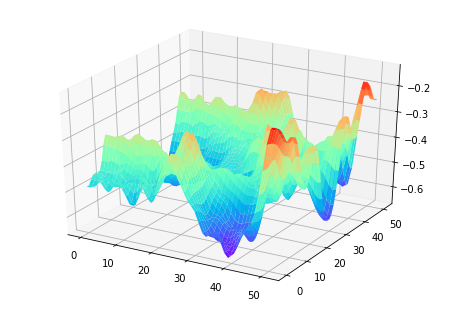

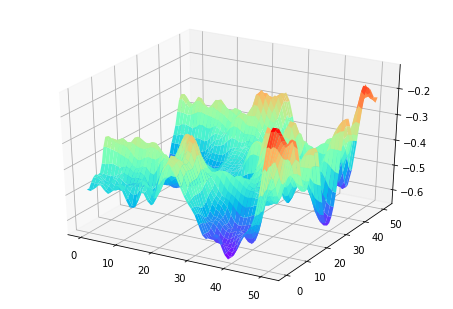

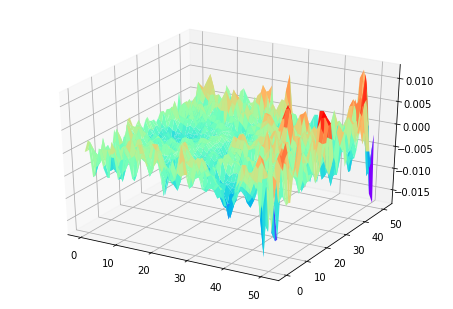

In [23]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1)
ax = Axes3D(fig)
X = np.arange(0, 52, 1)
#X = np.arange(-4, 4, 0.25)
Y = np.arange(0, 52, 1)
X, Y = np.meshgrid(X, Y)
Z = y_test[0][0]
Z1 = y_predict[0][0]

# 具体函数方法可用 help(function) 查看，如：help(ax.plot_surface)

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')

fig2 = plt.figure(2)
ax2 = Axes3D(fig2)
ax2.plot_surface(X, Y, Z1, rstride=1, cstride=1, cmap='rainbow')
plt.show()

fig3 = plt.figure(3)
ax3 = Axes3D(fig3)
ax3.plot_surface(X, Y, Z - Z1, rstride=1, cstride=1, cmap='rainbow')
plt.show()

#help(np.arange)
#help(ax.plot_surface)

In [24]:
print(train_size)
tmp_data, mxx, mnn = MinMaxNormalization(H)
X_test, y_test = init_data(tmp_data[train_size:, ], H.shape[0] - train_size, time_size)
print(mx, mn, mxx, mnn)

2000
1.96337231493 0.648396878095 1.96337231493 0.648396878095


In [172]:
print(y_test.shape[0])

7970


In [25]:
y_predict = model.predict(
    X_test[:1000], batch_size = 100, verbose = 1)
print(y_test.shape)
print(y_predict.shape)
print(y_test[0][0][0])
print(y_predict[0][0][0])
print(tmp_data[train_size+time_size][0:52])

1000/1000 [==============================] - 170s     
(7970, 1, 52, 52)
(1000, 1, 52, 52)
[-0.48491141 -0.48491141 -0.47998118 -0.46235999 -0.45626408 -0.47705913
 -0.48944992 -0.46924511 -0.44743669 -0.44944403 -0.46565574 -0.49152383
 -0.51979333 -0.52261132 -0.48926425 -0.45272788 -0.45174935 -0.48104075
 -0.49621016 -0.46449026 -0.40896013 -0.36785376 -0.338231   -0.321132
 -0.33449259 -0.36651862 -0.39703465 -0.42815626 -0.45774728 -0.47602218
 -0.49616379 -0.53463912 -0.57313365 -0.58531946 -0.57602835 -0.5

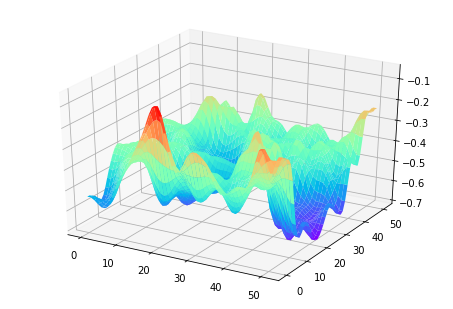

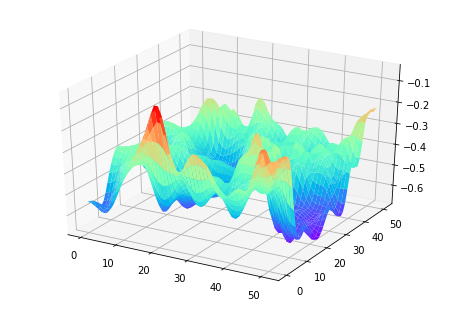

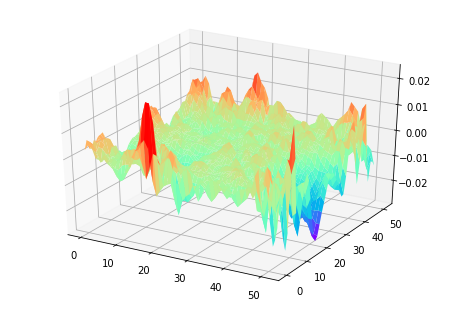

In [174]:
def draw_3D(y_test, y_predict):
    from matplotlib import pyplot as plt
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(1)
    ax = Axes3D(fig)
    X = np.arange(0, 52, 1)
    #X = np.arange(-4, 4, 0.25)
    Y = np.arange(0, 52, 1)
    X, Y = np.meshgrid(X, Y)
    Z = y_test[-1][0]
    Z1 = y_predict[-1][0]

    # 具体函数方法可用 help(function) 查看，如：help(ax.plot_surface)

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')

    fig2 = plt.figure(2)
    ax2 = Axes3D(fig2)
    ax2.plot_surface(X, Y, Z1, rstride=1, cstride=1, cmap='rainbow')
    plt.show()

    fig3 = plt.figure(3)
    ax3 = Axes3D(fig3)
    ax3.plot_surface(X, Y, Z - Z1, rstride=1, cstride=1, cmap='rainbow')
    plt.show()

    #help(np.arange)
    #help(ax.plot_surface)

In [26]:
def draw_3D(y_test, y_predict):
    from matplotlib import pyplot as plt
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure(1)
    ax = Axes3D(fig)
    X = np.arange(0, 52, 1)
    #X = np.arange(-4, 4, 0.25)
    Y = np.arange(0, 52, 1)
    X, Y = np.meshgrid(X, Y)
    Z = y_test[-1][0]
    Z1 = y_predict[-1][0]

    # 具体函数方法可用 help(function) 查看，如：help(ax.plot_surface)

    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='rainbow')

    fig2 = plt.figure(2)
    ax2 = Axes3D(fig2)
    ax2.plot_surface(X, Y, Z1, rstride=1, cstride=1, cmap='rainbow')
    plt.show()

    fig3 = plt.figure(3)
    ax3 = Axes3D(fig3)
    ax3.plot_surface(X, Y, Z - Z1, rstride=1, cstride=1, cmap='rainbow')
    plt.show()

    #help(np.arange)
    #help(ax.plot_surface)

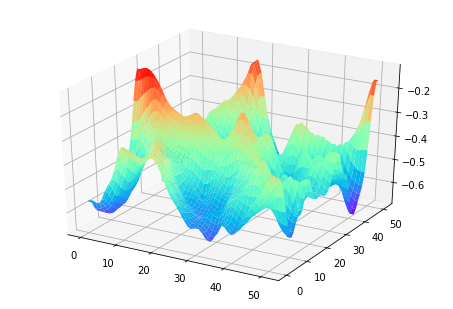

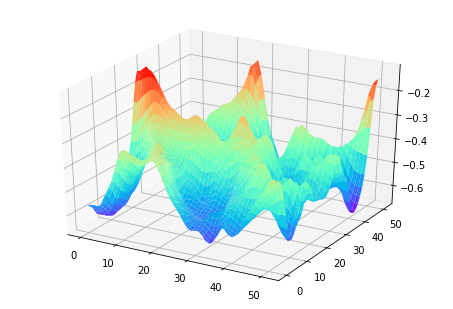

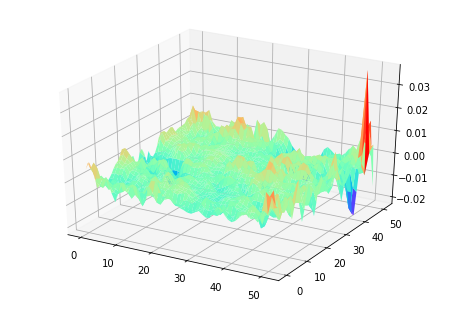

In [30]:
draw_3D(y_test[:1000], y_predict)

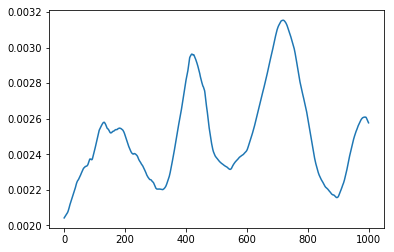

In [31]:
y_test_square = y_test.reshape(y_test.shape[0], 52 * 52)
y_predict_square = y_predict.reshape(y_predict.shape[0], 52 * 52)

len = y_predict_square.shape[0]
y_rmse = np.zeros(len)

for i in range(len):
    y_rmse[i] = np.sqrt(np.mean((y_test_square[i] - y_predict_square[i]) ** 2))
    y_rmse[i] = y_rmse[i] * (mx - mn) / 2.
    
plt.plot(y_rmse) # 如果没有第一个参数 x，图形的 x 坐标默认为数组的索引
plt.show() # 显示图形

In [76]:
import copy
iter_data = copy.deepcopy(tmp_data)
iter_predict = copy.deepcopy(y_predict)


In [77]:
#print(iter_test.shape)
for i in range(7000):
    iter_test,tmp = init_data(iter_data[train_size + i:], time_size + 1, time_size)
    #print(iter_test.shape)
    tmp_predict = model.predict(
        iter_test, batch_size = 1, verbose = 2)
    iter_predict[i] = copy.deepcopy(tmp_predict[0])
    iter_data[train_size + time_size + i] = copy.deepcopy(tmp_predict.reshape(52 * 52))
    

IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [ ]:
print(iter_data[train_size + time_size + 1000] == tmp_data[train_size+ time_size + 1000])
print(iter_data[train_size + time_size + 1000 - 31] == tmp_data[train_size+ time_size + 1000 - 31])

In [ ]:
y_test_square = y_test.reshape(y_test.shape[0], 52 * 52)
y_predict_square = y_predict.reshape(y_predict.shape[0], 52 * 52)
iter_predict_square = iter_predict.reshape(iter_predict.shape[0], 52 * 52)

len = y_test_square.shape[0]
y_rmse = np.zeros(len)
iter_y_rmse = np.zeros(len)

for i in range(1000):
    y_rmse[i] = np.sqrt(np.mean((y_test_square[i] - y_predict_square[i]) ** 2))
    y_rmse[i] = y_rmse[i] * (mx - mn) / 2.
    
    iter_y_rmse[i] = np.sqrt(np.mean((y_test_square[i] - iter_predict_square[i]) ** 2))
    iter_y_rmse[i] = iter_y_rmse[i] * (mx - mn) / 2.
    
plt.plot(y_rmse[:1000]) # 如果没有第一个参数 x，图形的 x 坐标默认为数组的索引
#plt.plot(iter_y_rmse)
plt.show() # 显示图形
plt.figure()
plt.plot(iter_y_rmse[:1000])
plt.show()

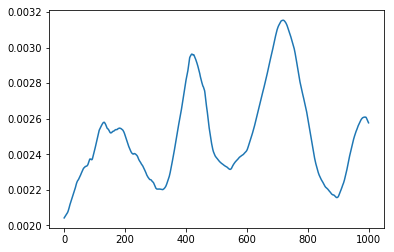

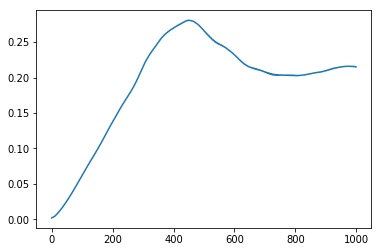

In [75]:
y_test_square = y_test.reshape(y_test.shape[0], 52 * 52)
y_predict_square = y_predict.reshape(y_predict.shape[0], 52 * 52)
iter_predict_square = iter_predict.reshape(iter_predict.shape[0], 52 * 52)

len = y_test_square.shape[0]
y_rmse = np.zeros(len)
iter_y_rmse = np.zeros(len)

for i in range(1000):
    y_rmse[i] = np.sqrt(np.mean((y_test_square[i] - y_predict_square[i]) ** 2))
    y_rmse[i] = y_rmse[i] * (mx - mn) / 2.
    
    iter_y_rmse[i] = np.sqrt(np.mean((y_test_square[i] - iter_predict_square[i]) ** 2))
    iter_y_rmse[i] = iter_y_rmse[i] * (mx - mn) / 2.
    
plt.plot(y_rmse[:1000]) # 如果没有第一个参数 x，图形的 x 坐标默认为数组的索引
#plt.plot(iter_y_rmse)
plt.show() # 显示图形
plt.figure()
plt.plot(iter_y_rmse[:1000])
plt.show()

In [27]:
from keras.models import model_from_json
json_string = 'model_json'
hyperparams_name = 'train_size1000.test_size100.time_size30.resunit12.lr0.0002'
#model = model_from_json(json_string)
model.load_weights(os.path.join('MODEL', '{}.final.best.h5'.format(hyperparams_name)))

In [28]:
y_predict = model.predict(
    X_test, batch_size = X_test.shape[0], verbose = 0)

In [29]:
print(y_predict[0].reshape(52, 52))
print(y_test[0].reshape(52, 52))

[[-0.65076959 -0.65095663 -0.64248204 ..., -0.46526781 -0.46570614
  -0.46544221]
 [-0.65437794 -0.6565026  -0.64323878 ..., -0.4653219  -0.46687043
  -0.46623573]
 [-0.66289467 -0.65977633 -0.65857714 ..., -0.46294367 -0.4664216
  -0.46629471]
 ..., 
 [-0.63852072 -0.64198571 -0.62920833 ..., -0.46444404 -0.4654766
  -0.46469963]
 [-0.64513922 -0.65021729 -0.64959902 ..., -0.46565038 -0.4656637
  -0.46501192]
 [-0.64755869 -0.64983624 -0.6458829  ..., -0.46458745 -0.46481097
  -0.46478304]]
[[-0.65994149 -0.65994149 -0.65505457 ..., -0.46253896 -0.46375144
  -0.46375144]
 [-0.65994149 -0.65990412 -0.65486282 ..., -0.4624404  -0.46369505
  -0.46375144]
 [-0.67213565 -0.67226428 -0.66590112 ..., -0.46143687 -0.46309742
  -0.46317276]
 ..., 
 [-0.63978088 -0.64093059 -0.63714868 ..., -0.46496755 -0.46509311
  -0.46509874]
 [-0.66608232 -0.66691691 -0.66328675 ..., -0.46506557 -0.46514606
  -0.46514964]
 [-0.66608232 -0.66608232 -0.66237146 ..., -0.4650723  -0.46514964
  -0.46514964]]


In [30]:
print(np.mean(np.abs(y_test[0] - y_predict[0])))

0.00324443
